In [14]:
import pandas as pd 
import numpy as np
from xgboost import XGBClassifier
import shap
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
train = pd.read_csv('../data/hr_tr.csv')
valid = pd.read_csv('../data/hr_val.csv')
test = pd.read_csv('../data/hr_te.csv')

In [3]:
print(train.columns)
print(valid.columns)
print(test.columns)

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC_re', 'WBC_re',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'Biopsy_HR'],
      dtype='object')
Index(['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC_re', 'WBC_re',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'Biopsy_HR'],
      dtype='object')
Index(['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC_re', 'WBC_re',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'Biopsy_HR'],
      dtype='object')


In [4]:
print(train.shape)
print(valid.shape)
print(test.shape)

(6171, 24)
(411, 24)
(1646, 24)


## Modeling

In [5]:
xgb = XGBClassifier(random_state = 2023, n_jobs=-1)

In [6]:
X_train = train.drop(['Biopsy_HR','RBC_re', 'WBC_re'], axis=1).copy()
y_train = train['Biopsy_HR'].copy()

X_valid = valid.drop(['Biopsy_HR','RBC_re', 'WBC_re'], axis=1).copy()
y_valid = valid['Biopsy_HR'].copy()

X_test = test.drop(['Biopsy_HR','RBC_re', 'WBC_re'], axis=1).copy()
y_test = test['Biopsy_HR'].copy()

In [7]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2023, ...)

In [8]:
y_valid

0      0
1      0
2      0
3      1
4      0
      ..
406    1
407    1
408    0
409    0
410    1
Name: Biopsy_HR, Length: 411, dtype: int64

### train

In [9]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [11]:
shap.initjs()

In [12]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


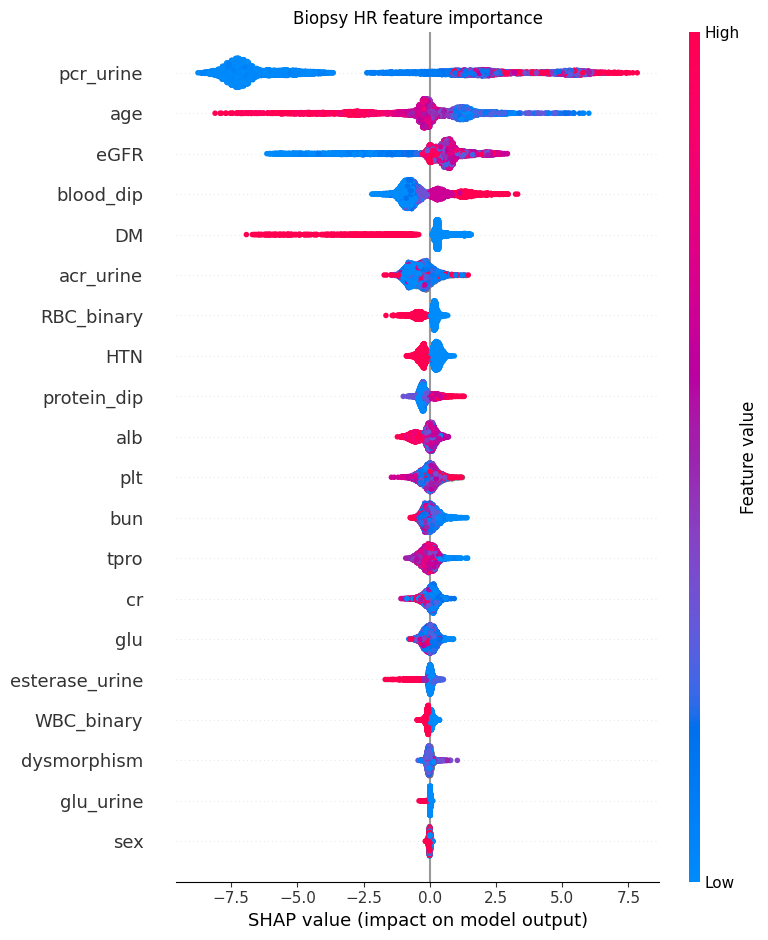

In [15]:
plt.figure(figsize=[10,10])

plt.title('Biopsy HR feature importance')
shap.summary_plot(shap_values, X_train)

plt.show()

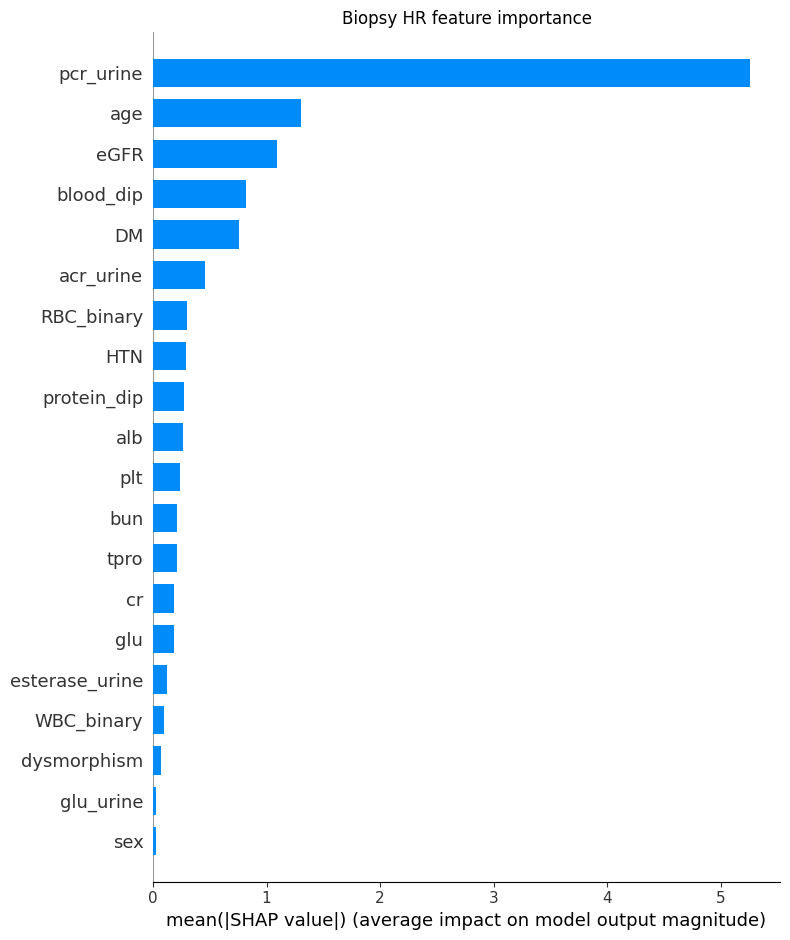

In [16]:
plt.figure(figsize=[10,10])

plt.title('Biopsy HR feature importance')
shap.summary_plot(shap_values, X_train, plot_type="bar")

plt.show()

In [17]:
train_pred = xgb.predict(X_train)
train_pred_prob = xgb.predict_proba(X_train)

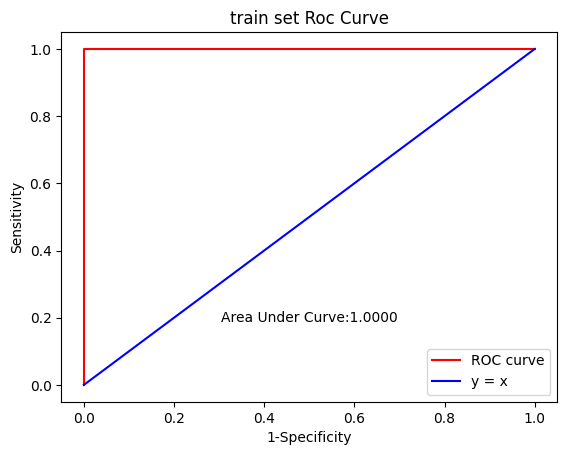

In [18]:
    # roc curve, auc validation set
    fpr, tpr, thresholds = roc_curve(np.array(y_train), train_pred_prob[:,1])

    # auc 계산

    plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
    plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

    auc = roc_auc_score(np.array(y_train), train_pred_prob[:,1])
    plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
    plt.title('train set Roc Curve')
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')

    plt.legend() # 그래프 라벨 표시

    plt.show()

In [19]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5189
           1       1.00      1.00      1.00       982

    accuracy                           1.00      6171
   macro avg       1.00      1.00      1.00      6171
weighted avg       1.00      1.00      1.00      6171



### valid

In [20]:
pred = xgb.predict(X_valid)
print(pd.DataFrame(pred).head())

pred_prob = xgb.predict_proba(X_valid)
print(pd.DataFrame(pred_prob[:,1]).head())

   0
0  0
1  0
2  0
3  1
4  0
          0
0  0.000027
1  0.000020
2  0.000003
3  0.994517
4  0.000010


In [21]:
pred_prob.shape

(411, 2)

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [23]:
y_valid

0      0
1      0
2      0
3      1
4      0
      ..
406    1
407    1
408    0
409    0
410    1
Name: Biopsy_HR, Length: 411, dtype: int64

In [24]:
accuracy = accuracy_score(y_valid, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.35%


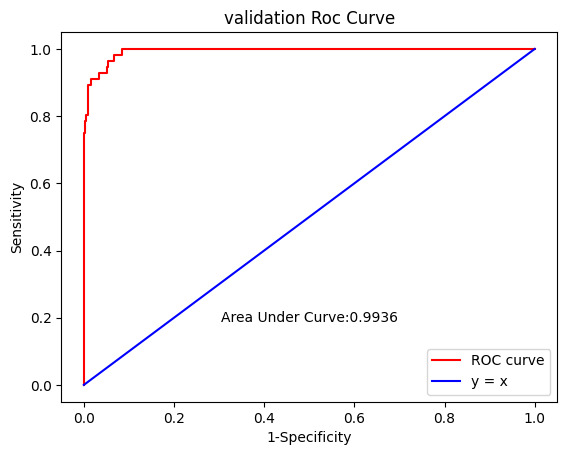

In [25]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(y_valid), pred_prob[:,1])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(y_valid), pred_prob[:,1])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('validation Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [26]:
print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       355
           1       0.84      0.91      0.87        56

    accuracy                           0.96       411
   macro avg       0.91      0.94      0.93       411
weighted avg       0.97      0.96      0.96       411



#### test

In [27]:
test_pred = xgb.predict(X_test)
test_pred_prob = xgb.predict_proba(X_test)

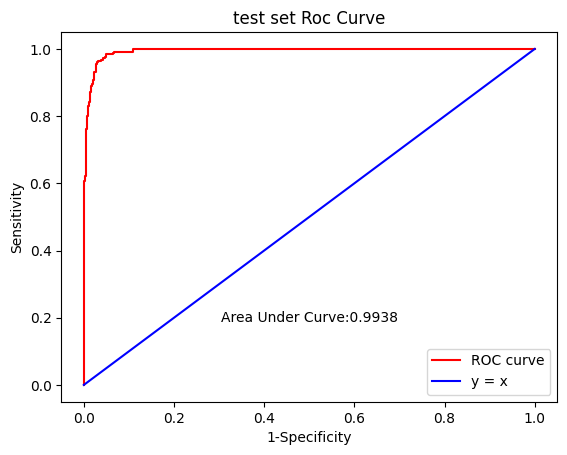

In [28]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(y_test), test_pred_prob[:,1])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(y_test), test_pred_prob[:,1])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('test set Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [29]:
accuracy = accuracy_score(y_test, test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.84%


In [30]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1394
           1       0.88      0.91      0.90       252

    accuracy                           0.97      1646
   macro avg       0.93      0.95      0.94      1646
weighted avg       0.97      0.97      0.97      1646



#### 비교하기

In [31]:
tt = pd.read_csv('../data/test.csv')
vv = pd.read_csv('../data/validation.csv')

In [32]:
print(tt['hr_proba'])
print(vv['hr_proba'])

0       0.995405
1       0.998754
2       0.998595
3       0.999789
4       0.998452
          ...   
1641    0.999981
1642    0.999970
1643    0.999586
1644    0.996002
1645    0.999842
Name: hr_proba, Length: 1646, dtype: float64
0      0.999161
1      0.999693
2      0.999958
3      0.191005
4      0.999709
         ...   
406    0.003759
407    0.004759
408    0.999965
409    0.997291
410    0.012347
Name: hr_proba, Length: 411, dtype: float64


In [33]:
print(pd.DataFrame(test_pred_prob[:,0]))
print(pd.DataFrame(pred_prob[:,0]))

             0
0     0.999910
1     0.999679
2     0.999949
3     0.999991
4     0.999935
...        ...
1641  0.999999
1642  0.999996
1643  0.999989
1644  0.999882
1645  0.999969

[1646 rows x 1 columns]
            0
0    0.999973
1    0.999980
2    0.999997
3    0.005483
4    0.999990
..        ...
406  0.000213
407  0.000202
408  0.999994
409  0.999926
410  0.004118

[411 rows x 1 columns]
